# Part 1: Equivalent circuit network modelling of a lithium ion barrtey - Thevenin Model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir =os.path.join(drive_dir, 'battery_experimental_data')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    
from tools import *

## Load data

In [2]:
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')
testing_data = pd.read_csv(os.path.join(data_dir, 'Battery_Testing_Data.csv'), header=0, skiprows=[1])

display(SOC_OCV_data.head())
display(testing_data.head())

,SOC,Ecell/V
0,100.000000,4.186240
1,99.998926,4.186390
2,99.997852,4.186268
3,99.996778,4.186108
4,99.995704,4.186100


,Time (s),Current (mA),Voltage (V),Temperature
0,1,0.0,4.05,21.96
1,2,0.0,4.05,21.94
2,3,0.0,4.05,21.94
3,4,0.0,4.05,21.93
4,5,0.0,4.05,21.93


In [3]:
# extract values in numpy array
ref_SOC = SOC_OCV_data['SOC'].values               # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values           # unit in V

t = testing_data['Time (s)'].values                # unit in s
# negative as the battery starts from charging with negative currents (double check this)
I = -testing_data['Current (mA)'].values / 1000    # unit in A
V_actual = testing_data['Voltage (V)'].values      # unit in V

## Model

In [4]:
V_initial = V_actual[0]
# initial SOC (see usage of function in tools.py)
z0 = match_val(V_initial, ref_OCV, ref_SOC)
print('Initial SOC: {}%'.format(z0))
R = 0.018  # resistance (ohm)
Q = 2500   # total capacity (mAh)
eta = 1    # colulombic efficiency 

N = len(t)
z = np.ndarray(N)
V_pred = np.ndarray(N)
OCV_pred = np.ndarray(N)
z[0] = z0

for i in range(N):
    # Predicted Voltage
    OCV_pred[i] = match_val(z[i], ref_SOC, ref_OCV)
    V_pred[i] = OCV_pred[i] - I[i] * R
    
    # update State of charge (SOC)
    if i != N-1:
        update_SOC(i, z, t, I, eta, Q)

Initial SOC: 85.95454511%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


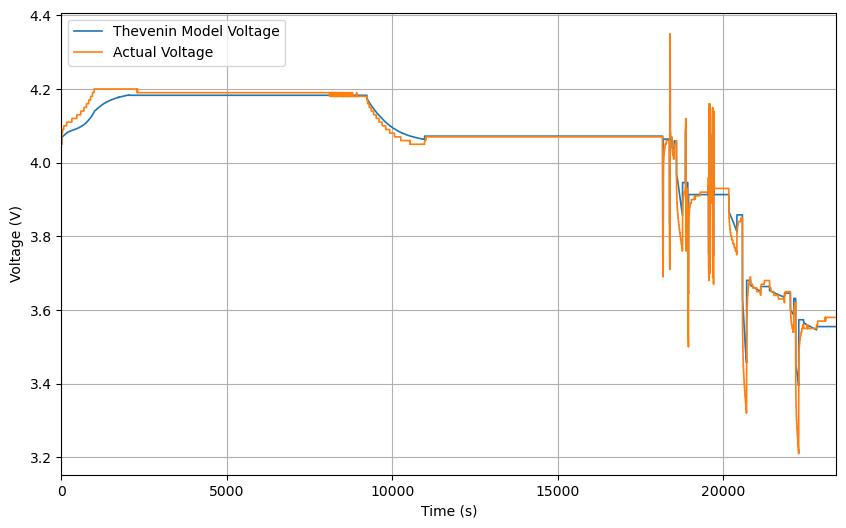

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, V_pred, label='Thevenin Model Voltage', linewidth=1.2)
ax.plot(t, V_actual, label='Actual Voltage', linewidth=1.2)
ax.legend()
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
# ax.set_title('Thevenin Model Prediction')
ax.grid()
fig.savefig('Figures/Part 1/part1_V.eps', format='eps')
plt.show()

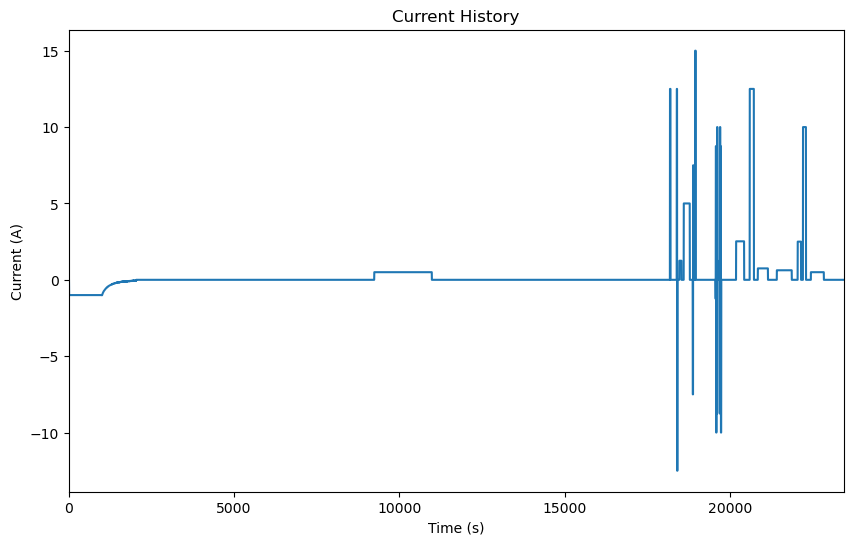

In [6]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, I)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')
ax.set_title('Current History')
plt.show()

## Error Analysis

In [7]:
error = V_pred - V_actual
error_pct = (V_pred - V_actual) / V_actual

max_idx = np.argmax(np.abs(error))
max_err = error[max_idx]
t_max_err = t[max_idx]

max_idx_pct = np.argmax(np.abs(error_pct))
max_err_pct = error_pct[max_idx_pct]
t_max_err_pct = t[max_idx_pct]

print("Maximum error is {:.4f} V, at t = {} s".format(max_err, t_max_err))
print("Maximum percentage error is {:.4f}%, at t = {} s".format(max_err_pct*100, t_max_err_pct))

print()

avg_err = np.mean(np.abs(error))
avg_err_pct = np.mean(np.abs(error_pct))

print("Average error (absolute) is {:.4f} V".format(avg_err))
print("Average percentage error (absolute) is {:.4f}%".format(avg_err_pct*100))

print()

rms = np.sqrt(np.mean(np.square(error)))
print("RMS error is {:.4f} V".format(rms))

Maximum error is 0.1871 V, at t = 18395 s
Maximum percentage error is 5.8007%, at t = 22288 s

Average error (absolute) is 0.0126 V
Average percentage error (absolute) is 0.3221%

RMS error is 0.0236 V


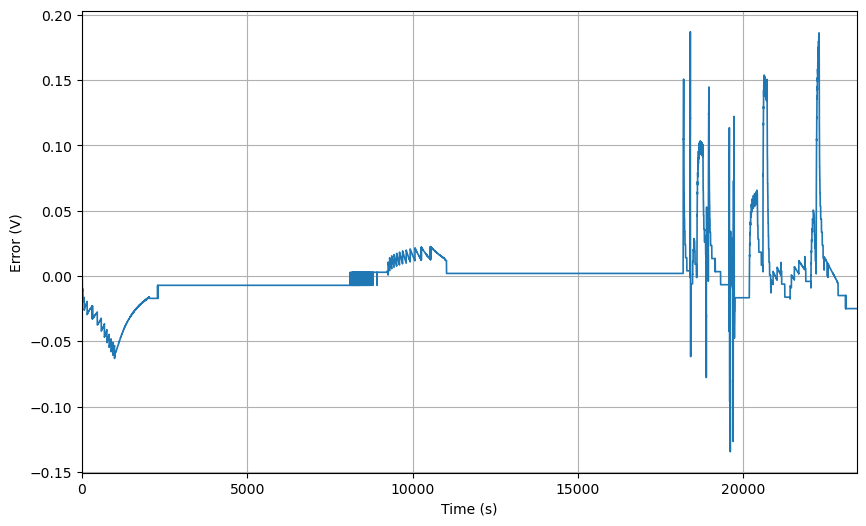

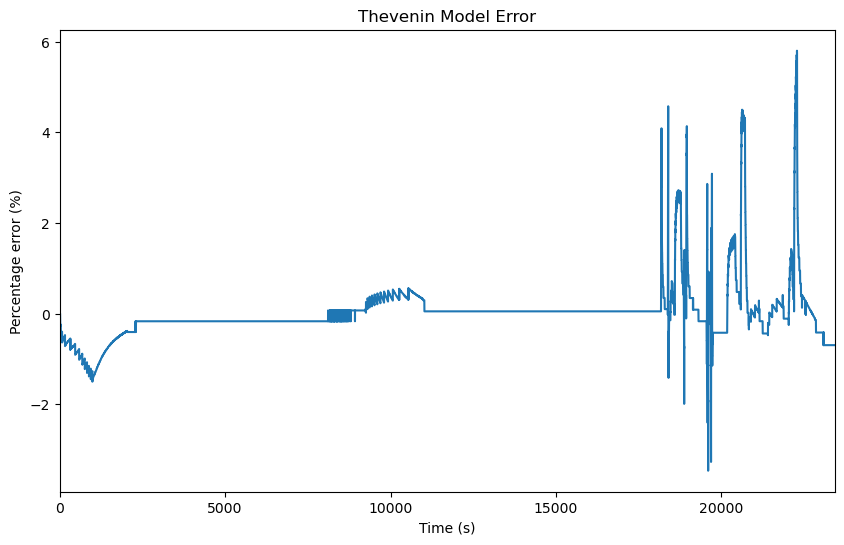

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, error, linewidth=1.2)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Error (V)')
# ax.set_title('Thevenin Model Error')
ax.grid()
fig.savefig('Figures/Part 1/part1_V_error.eps', format='eps')
plt.show()

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, error_pct*100)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Percentage error (%)')
ax.set_title('Thevenin Model Error')
plt.show()


Answer to 3.2:

When the current changes by a large amount quickly, the discrete time integration of z(t) becomes inaccurate. This gives an inaccurate estimation of the state of charge and results in a large error in Voltage.

### Zoom in for report:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


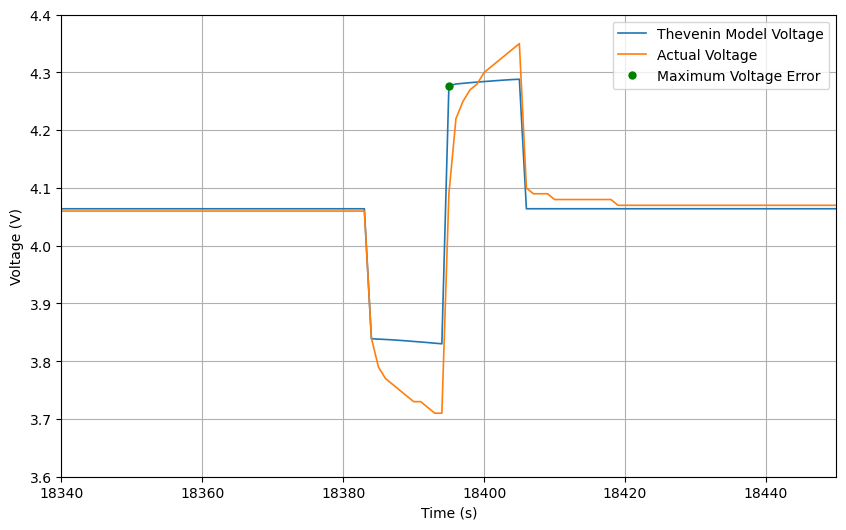

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, V_pred, label='Thevenin Model Voltage', linewidth=1.2)
ax.plot(t, V_actual, label='Actual Voltage', linewidth=1.2)
ax.plot(t[max_idx], V_pred[max_idx], 'g.', label='Maximum Voltage Error', markersize=10)
ax.legend()
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_xlim([18340, 18450])
ax.set_ylim([3.6, 4.4])
# ax.set_title('Thevenin Model Prediction')
ax.grid()
fig.savefig('Figures/Part 1/part1_V_max_error_zoomed_in.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


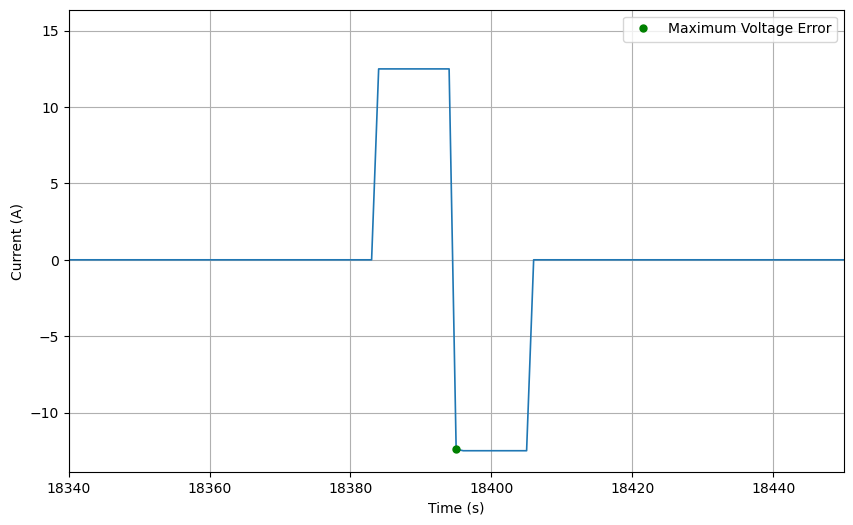

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, I, linewidth=1.2)
ax.plot(t[max_idx], I[max_idx], 'g.', markersize=10, label='Maximum Voltage Error')
ax.legend()
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')
ax.set_xlim([18340, 18450])
ax.grid()
ax.legend()
# ax.set_title('Current History')
fig.savefig('Figures/Part 1/part1_I_max_error_zoomed_in.eps', format='eps')
plt.show()